In [6]:
import matplotlib.pyplot as plt
import numpy as np
from graspy.simulations import sbm
from numpy.random import normal, poisson
from scipy.stats import norm
import random
import itertools
from math import exp as ex
from math import log
import matplotlib.pyplot as plt
from load_dataset import load_UMich
from graspy.plot import heatmap
%matplotlib inline

In [7]:
def fit_cls(A,e,y,iter,a,rho,count):
    sampleNo,_,_ = A.shape
    R = np.ones((dim,N), dtype=float)/(dim*N)
    C = np.ones((N,1), dtype=float)/N
    b = 0
    ls = []

    for itr in range(1,iter):
        gradR = np.zeros((dim,N))/(dim*N)
        gradC = np.zeros((N,1))/N
        gradb = 0
        for k in range(0,sampleNo):
            tmp = b
            tmpGradR = np.zeros((dim,N)) 
            for i in range(0,dim):
                if y[k] == i:
                    tmp -= e[i,:].T@R@A[k,:,:]@C/count[i]
                    tmpGradR -= e[i,:].reshape(-1,1)@C.T@A[k,:,:].T/count[i]
                else:
                    tmp += e[i,:].T@R@A[k,:,:]@C/count[i]
                    tmpGradR += e[i,:].reshape(-1,1)@C.T@A[k,:,:].T/count[i]
            
            phi = ex(tmp)
            phi_ = phi/(1+phi)
            
            gradR += phi_*tmpGradR

        gradR = gradR/sampleNo + rho*np.sign(R)   
        R = R - a*gradR
        
        for k in range(0,sampleNo):
            tmp = b 
            tmpGradC = np.zeros((N,1))
            for i in range(0,dim):
                if y[k] == i:
                    tmp -= e[i,:].T@R@A[k,:,:]@C/count[i]
                    tmpGradC -= A[k,:,:].T@R.T@e[i,:].reshape(-1,1)/count[i]
                else:
                    tmp += e[i,:].T@R@A[k,:,:]@C/count[i]
                    tmpGradC += A[k,:,:].T@R.T@e[i,:].reshape(-1,1)/count[i]
            
            phi = ex(tmp)
            phi_ = phi/(1+phi)
            
            gradC += phi_*tmpGradC

        gradC = gradC/sampleNo + rho*np.sign(C)
        C = C - a*gradC
        
        for k in range(0,sampleNo):
            tmp = b 
            tmpGradC = np.zeros((N,1))
            for i in range(0,dim):
                if y[k] == i:
                    tmp -= e[i,:].T@R@A[k,:,:]@C/count[i]
                else:
                    tmp += e[i,:].T@R@A[k,:,:]@C/count[i]
            
            phi = ex(tmp)
            
            gradb += phi/(1+phi)
            
        b = b - a*gradb/sampleNo
        
    return R,C,b

In [8]:
def predictAccuracy(R,C,b,e,A,y):
    l = len(y)
    accuracy = 0

    for i in range(0,l):
        lbl = np.argmax(e@R@A[i,:,:]@C)
        #print(e@R@A[i,:,:]@C,y[i])
        #print('hi')
        if lbl == y[i]:
            accuracy += 1

    return accuracy*100/l

In [9]:
def getBase(dim):
    e = np.zeros((dim,dim),dtype=float)
    labelVec = np.asarray(range(1,dim+1),dtype=float)
    e[0,:] = labelVec/(labelVec@labelVec.T)**.5

    for i in range(1,dim):
        tmp = np.roll(labelVec,i)
        tmp = tmp.reshape(1,-1)
        tmp_ = tmp.copy()
        for j in range(0,i):
            eTmp = e[j,:].reshape(1,-1)
            tmp_ -= (tmp@eTmp.T/(eTmp@eTmp.T))*eTmp
            #print(tmp.shape)
        e[i,:] = tmp_/(tmp_@tmp_.T)**.5
    return e


In [17]:
crossValidate = 10
accuracy = 0

A, y = load_UMich(ptr=True)
_,count = np.unique(y, return_counts=True)
dim = len(count)
e = getBase(dim)
totalSample, N, _ = A.shape

count = count/totalSample
indx = np.asarray(range(0,totalSample))
random.shuffle(indx)

testSample = int(totalSample/crossValidate)
for i in range(0,crossValidate):
    print("Doing test on %d fold.........\n"%(i+1))
    _,count = np.unique(y[indx[0:totalSample-testSample]], return_counts=True)
    count = count/(totalSample-testSample)
    
    print(count)
    indx = np.roll(indx,testSample)
    R,C,b = fit_cls(A[indx[0:totalSample-testSample],:,:],e,y[indx[0:totalSample-testSample]],4000,1e-2,6e-4,count)
    testAccuracy = predictAccuracy(R,C,b,e,A[indx[totalSample-testSample:totalSample],:,:],y[indx[totalSample-testSample:totalSample]])
    accuracy += testAccuracy
    print(testAccuracy)

accuracy = accuracy/crossValidate
print("Total accuracy %f\n"%accuracy)


Doing test on 1 fold.........

[0.5 0.5]
85.71428571428571
Doing test on 2 fold.........

[0.5 0.5]
85.71428571428571
Doing test on 3 fold.........

[0.5 0.5]
71.42857142857143
Doing test on 4 fold.........

[0.51388889 0.48611111]
71.42857142857143
Doing test on 5 fold.........

[0.48611111 0.51388889]
57.142857142857146
Doing test on 6 fold.........

[0.52777778 0.47222222]
100.0
Doing test on 7 fold.........

[0.51388889 0.48611111]
57.142857142857146
Doing test on 8 fold.........

[0.5 0.5]
71.42857142857143
Doing test on 9 fold.........

[0.5 0.5]
57.142857142857146
Doing test on 10 fold.........

[0.51388889 0.48611111]
71.42857142857143
Total accuracy 72.857143



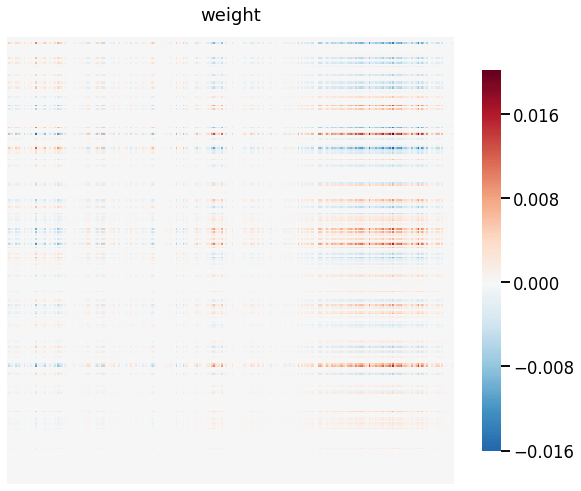

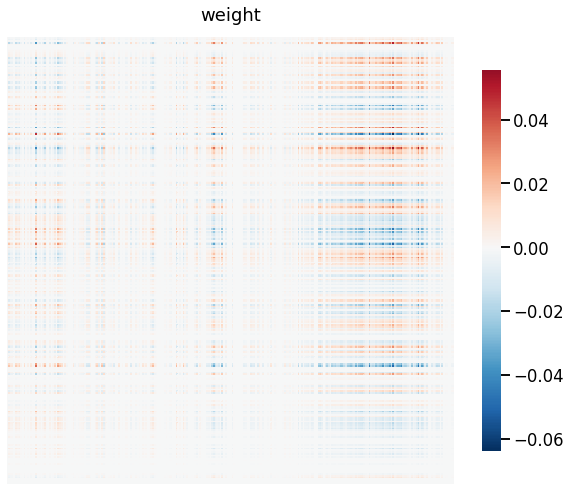

In [18]:
tm1 = R[0,:].reshape(-1,1)@C.T
tm = R[1,:].reshape(-1,1)@C.T
heatmap(tm1, title ='weight')
heatmap(tm, title ='weight')

In [12]:
e

array([[ 0.4472136 ,  0.89442719],
       [ 0.89442719, -0.4472136 ]])